## Projet APST2 Reinforcement Part 1: q-learning & SARSA applied to the Frozen Lake problem

#### Roig Sébastien, Defossez Floran, Chopard Gatien, Gougeon Natacha

In [1]:
import gymnasium as gym
import pygame
import numpy as np
import matplotlib.pyplot as plt

## The Frozen Lake

In [17]:
env = gym.make("FrozenLake-v1", render_mode = "human")
print(f'Number of possible actions: {env.action_space} that correspond to left, down, right, up')
print(f'Number of states: {env.observation_space} that correspond to a 4x4 grid of positions')

Number of possible actions: Discrete(4) that correspond to left, down, right, up
Number of states: Discrete(16) that correspond to a 4x4 grid of positions


Frozen lake involves crossing a frozen lake from Start to Goal without falling into any Holes by walking over the Frozen lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake.

#### Action Space
The agent takes a interger for action, where that integer decides direction to move in which can be:

- 0: LEFT
- 1: DOWN
- 2: RIGHT
- 3: UP

#### Observation Space
The observation is a value representing the agent’s current position as current_row * nrows + current_col. For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15.

#### Rewards

- Reach goal: 1
- Reach hole: 0
- Reach frozen: 0

Here bellow, you can test the situation with the directional keys of your keyboard. For convinance, the lake is not slippery.

In [18]:
env = gym.make("FrozenLake-v1", render_mode = "human", is_slippery = False)
env.reset()

running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            break
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_LEFT:
                observation, reward, terminated, truncated, info = env.step(0)
            elif event.key == pygame.K_DOWN:
                observation, reward, terminated, truncated, info = env.step(1)
            elif event.key == pygame.K_RIGHT:
                observation, reward, terminated, truncated, info = env.step(2)
            elif event.key == pygame.K_UP:
                observation, reward, terminated, truncated, info = env.step(3)
            else:
                continue
            if terminated:
                env.reset()
env.close()

## Q-Learning

We propose to build a policy using the q-learning agrithm

In [19]:
class Qleanning:

    def __init__(self, n_episode, alpha, gamma, decay=None):
        self.n_episode = n_episode
        self.alpha = alpha
        self.gamma = gamma
        self.decay = decay

        self.policy = np.zeros((16,4))
        self.history = np.zeros(n_episode)

    def train(self, plot=True):

        env = gym.make("FrozenLake-v1")
        env.reset()
        
        for i in range(self.n_episode):
            n_move = 0
            env.reset()
            terminated = False
            while not terminated:
                if n_move > 5000:
                    raise Exception("Failed to find policy")
                n_move += 1
                state = env.s
                # may choose a random action if using eps-greedy
                if self.decay is not None and np.random.rand() < np.exp(-self.decay*i):
                    action = np.random.randint(4)
                # choose a random action if policy is not defined
                elif not np.any(self.policy[state,:]):
                    action = np.random.randint(4)
                # follow the policy
                else:
                    action = np.argmax(self.policy[state,:])
                new_state, reward, terminated, truncated, info = env.step(action)
                self.history[i] += reward
                qmaxnew = np.max(self.policy[new_state,:])
                self.policy[state, action] = (1-self.alpha)*self.policy[state, action] + self.alpha*(reward + self.gamma*qmaxnew)
        env.close()
        if plot:
            plt.plot(np.convolve(self.history, np.ones(70), 'valid')/70, c = 'b')
            plt.xlabel('episode')
            plt.ylabel('reward')
            plt.title('evolution of reward per episode q-learning')
            plt.show()
    
    def performance(self, n, plot=True):
        env = gym.make("FrozenLake-v1")
        rewards = np.zeros(n)
        n_steps = np.zeros(n)
        env.reset()
        for i in range(n):
            terminated = False
            env.reset()
            while not terminated:
                state = env.s
                action = np.argmax(self.policy[state,:])
                new_state, reward, terminated, truncated, info = env.step(action)
                n_steps[i] += 1
                rewards[i] += reward
        env.close()
        if plot:
            plt.boxplot(n_steps)
            plt.ylabel('number of steps')
            plt.show()
            print(f"Win rate: {np.mean(rewards)}")

        return rewards, n_steps

It is difficult to set the parameters of the agorithm to have an acceptable policy.
With $\alpha = 0.5 , \gamma = 1$ and an exponential decay with a $0.01$ factor, we get good results. However, we notice that sometimes the algorithm gets stuck in an episode and can't finish it. To address this issue we can set the epsilon values with a less decreassing function but the resulting policy is not as good. We decided to keep those parameters and assume that we may have to execute multiple times our code.

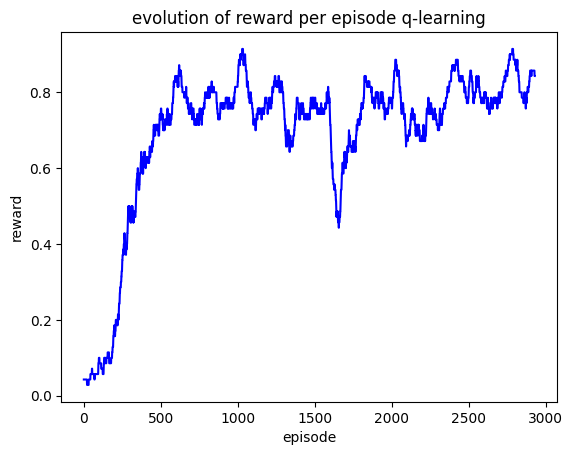

In [20]:
qleanning = Qleanning(3000, 0.5, 1, 0.01)
qleanning.train()

Here above, we have the evolution of the wining rate during the along the episodes, we represented the rolling average over 70 episodes the smooth the curve.

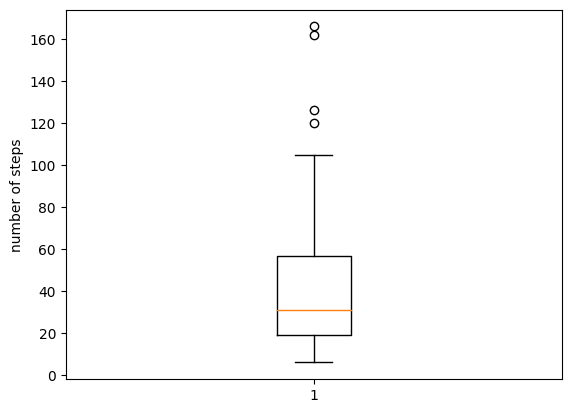

Win rate: 0.71


In [21]:
qleanning.performance(100);

For the resulting policy, we printed above the win rate and the boxplot of the numbers of steps per games over 100 games. Also, we want to display the computed policy with the following piece of code

In [22]:
def draw_policy(policy):
    env = gym.make("FrozenLake-v1", render_mode = "rgb_array")
    env.reset()
    env.render()
    image = env.window_surface
    env.close()
    for n_line in range(4):
        for n_col in range(4):
            direcion = np.argmax(policy[n_line*4 + n_col])
            if direcion == 0:
                arrow = [(16+n_col*64,32+n_line*64),(48+n_col*64,16+n_line*64),(48+n_col*64,48+n_line*64)]
            elif direcion ==1:
                arrow = [(16+n_col*64,16+n_line*64),(48+n_col*64,16+n_line*64),(32+n_col*64,48+n_line*64)]
            elif direcion == 2:
                arrow = [(16+n_col*64,16+n_line*64),(48+n_col*64,32+n_line*64),(16+n_col*64,48+n_line*64)]
            elif direcion == 3:
                arrow = [(16+n_col*64,48+n_line*64),(32+n_col*64,16+n_line*64),(48+n_col*64,48+n_line*64)]
            pygame.draw.polygon(image, (50,50,50), arrow)
    image = pygame.surfarray.array3d(image).transpose(1,0,2)
    image = np.concatenate([image, 255*np.ones((256,256,1), dtype='uint8')], axis=2)
    plt.axis("off")
    plt.imshow(image)
    plt.show()

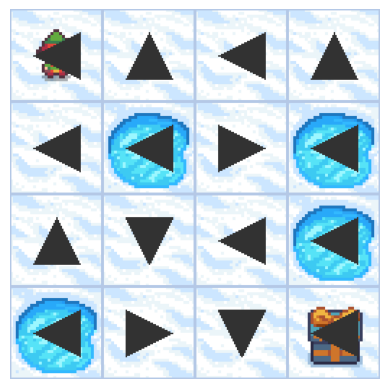

In [23]:
draw_policy(qleanning.policy)

## SARSA

Let's try the SARSA algorithm. Unlike q-learning, SARSA is an on-policy, but the both algorithm are almost the same in terms of code.

In [10]:
class SARSA:

    def __init__(self, n_episode, alpha, gamma, decay=None):
        self.n_episode = n_episode
        self.alpha = alpha
        self.gamma = gamma
        self.decay = decay

        self.policy = np.zeros((16,4))
        self.history = np.zeros(n_episode)

    def train(self, plot=True):

        def select_action(state,i):
            # may choose a random action if using eps-greedy
            if self.decay is not None and np.random.rand() < np.exp(-self.decay*i):
                action = np.random.randint(4)
            # choose a random action if policy is not defined
            elif not np.any(self.policy[state,:]):
                action = np.random.randint(4)
            # follow the policy
            else:
                action = np.argmax(self.policy[state,:])
            return action

        env = gym.make("FrozenLake-v1")
        env.reset()
        
        for i in range(self.n_episode):
            n_move = 0
            env.reset()
            terminated = False
            state = env.s
            action = select_action(state, i)
            while not terminated:
                n_move += 1
                if n_move > 5000:
                    raise Exception("Failed to find policy")
                new_state, reward, terminated, truncated, info = env.step(action)
                self.history[i] += reward
                new_action = select_action(new_state, i)

                self.policy[state, action] = (1-self.alpha)*self.policy[state, action] + self.alpha*(reward + self.gamma*self.policy[new_state,new_action])
                state = new_state
                action = new_action

        env.close()
        if plot:
            plt.plot(np.convolve(self.history, np.ones(70), 'valid')/70, c = 'b')
            plt.xlabel('episode')
            plt.ylabel('reward')
            plt.title('evolution of reward per episode SARSA')
            plt.show()
    
    def performance(self, n, plot=True):
        env = gym.make("FrozenLake-v1")
        rewards = np.zeros(n)
        n_steps = np.zeros(n)
        env.reset()
        for i in range(n):
            terminated = False
            env.reset()
            while not terminated:
                state = env.s
                action = np.argmax(self.policy[state,:])
                new_state, reward, terminated, truncated, info = env.step(action)
                n_steps[i] += 1
                rewards[i] += reward
        env.close()
        if plot:
            plt.boxplot(n_steps)
            plt.ylabel('number of steps')
            plt.show()
            print(f"Win rate: {np.mean(rewards)}")

        return rewards, n_steps

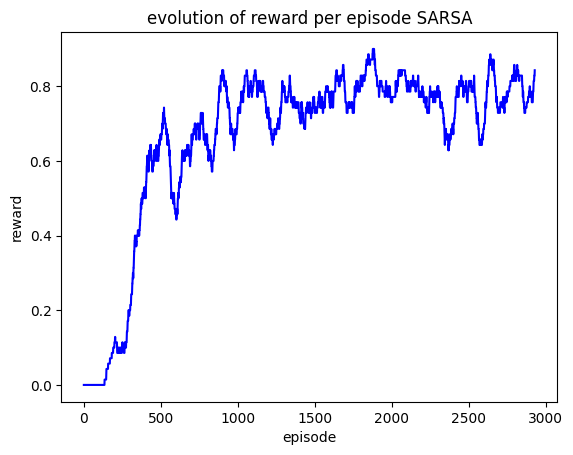

In [12]:
sarsa = SARSA(3000, 0.5, 1, 0.01)
sarsa.train()

Here above the rolling average of the evolution of the winning rate along the episode during the training

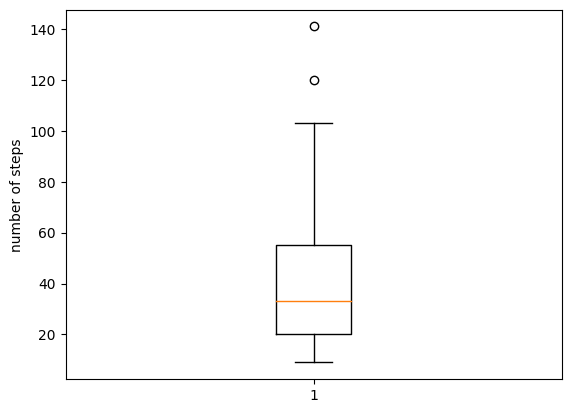

Win rate: 0.79


In [140]:
sarsa.performance(100);

For the resulting policy, we printed above the win rate and the boxplot of the numbers of steps per games over 100 games. Also, here below, the computed policy

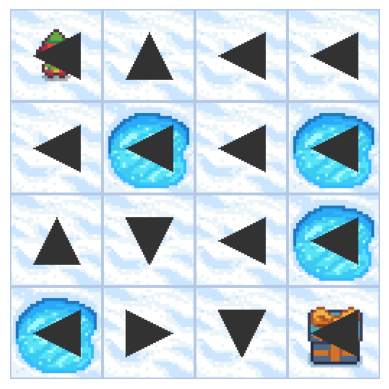

In [24]:
draw_policy(sarsa.policy)

We can see that the policy is slightly different from qlearning but it seem that the global strategy is the same.

Like for q-learning, it is difficult to tune the parameters of the algorithm, however we noticed that it almost never failed to find a policy but that policy is not always good. From one execution to an other there is a lot of variation of the performance.

As our algorithms are not super stable, it is complicated to compare their performance. Still we can say that SARSA is more robust during the training but may lead to bad policy, on its side q-learning only give good policy when we use an $\epsilon$-greedy strategy with a small decay rate but it may get stuck and fail to find any policy.

Overall, we conclude that our algorithm provides good results as long as we use the proper parameters and we watch the resulting policy. An idea to improve the robustness of our algorithms is to implement a better heuristic that prevent games to last too long.